# **Intro**
In this notebook I set up semi-supervised VAE that attempts to predict the digit from MNIST numbers.
In this vanilla semi-supervised VAE (ssVAE), we use the digits as labels.
We omit some labels so that it is semi-supervised.
Also, we use the M2 formulation of semi-supervised as described here: "Semi-supervised Learning with Deep Generative Models", https://arxiv.org/abs/1406.5298

A lot of the model code was taken from this tutorial: https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb

And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning 
with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/






# **Github / VM setup**

To integrate Colab with github, we need to do some setup first.
If you want this to integrate with your own github repo, you will need to create a `secrets` folder that contain your public and private key, and register this to access you github repo. Check `setup.sh` for more details.

In [1]:
import os, sys

NB_ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood'
sys.path.append('/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood')

In [273]:
# prelude: set up git, etc.
%cd {NB_ROOT_PATH}
!( source setup.sh )

/content/drive/MyDrive/Colab Notebooks/checkouts/sc_bulk_ood
Ensuring ssh keys exist...
Copied key(s) to /root/.ssh/
total 16
-rw-r--r-- 1 root root   43 Aug  6 22:49 config
-rw------- 1 root root  432 Aug  6 22:49 id_rsa
-rw-r--r-- 1 root root  113 Aug  6 22:49 id_rsa.pub
-rw-r--r-- 1 root root 2652 Aug  6 22:44 known_hosts


In [274]:
%%bash
# do your git operations here
git push
git status


On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   experiments/ssvae_mnist.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


Everything up-to-date


# **Imports**

In [275]:
# general imports
import warnings
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Softmax, ReLU
from keras.layers.merge import concatenate as concat
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.datasets import mnist
from tensorflow.keras.activations import relu
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score



# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from sklearn.manifold import TSNE

# programming stuff
import time
import os
import pickle
from pathlib import Path

# Load the TensorBoard notebook extension
%load_ext tensorboard

# load methods from other files
from mnist_preprocessing import generate_data as gd

# I disable eager execution ... forgot why
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

warnings.filterwarnings('ignore')
%pylab inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Populating the interactive namespace from numpy and matplotlib


# **Import and Pre-process data**
Import + reshape the MNIST data

In [276]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

print(y_train[0:5])

(60000, 28, 28)
(10000, 28, 28)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


# **Model Definition**
Hyperparameters

In [277]:
m = 250 # batch size
n_epoch = 50

# the network dimensions are 784 > 512 > proportion_dim < 512 < 784
n_z = 10 # latent space size, one latent dimension PER MNIST digit
encoder_dim = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer

activ = 'relu'
optim = Adam(learning_rate=0.001)

n_x = X_train.shape[1]
n_y = y_train.shape[1]

print(f"length of X {n_x} and length of y {n_y}")



length of X 784 and length of y 10


Encoder

In [278]:
# declare the Keras tensor we will use as input to the encoder
_X = Input(batch_shape=(m, n_x))
_Y = Input(batch_shape=(m, n_y))

# set up encoder network
# this is an encoder with 512 hidden layer
# Dense is a functor, with given initializations (activation and hidden layer dimension)
# After initialization, the functor is returned and inputs is used as an arguement
encoder_h = Dense(encoder_dim, activation=activ, name="encoder_1")(_X)

# now from the hidden layer, you get the mu and sigma for 
# the latent space
mu = Dense(n_z, activation='linear', name = "mu")(encoder_h)
l_sigma = Dense(n_z, activation='linear', name = "sigma")(encoder_h)



Latent Space

In [279]:
# now we need the sampler from mu and sigma
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

def null_f(args):
    return args

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ), name="z_samp")([mu, l_sigma])
z_l = Lambda(null_f, output_shape = (n_z, ), name="z_null")(z)

#defining the architecture of the classifier
class_hidden1 = Dense(n_z, activation=activ, name = "cls_h1")
class_out = Dense(n_z, activation='softmax', name="cls_out")

classifier_h1 = class_hidden1(z_l)
_Y_cls = class_out(classifier_h1)


# again, this is kind of conditional, since we are using
# the classifier labels.... 
# we merge latent space with label or the predicted label
zc_labeled = concat([z, _Y])

zc_unlabeled = concat([z, _Y_cls])


Classifier

Decoder

In [280]:
# set up decoder network
decoder_hidden = Dense(decoder_dim, activation=activ, name = "decoder_h1")
decoder_out = Dense(decoder_out_dim, activation='sigmoid', name = "decoder_out")


# this is the LABELED decoder
d_h1_lab = decoder_hidden(z)
d_out_lab = decoder_out(d_h1_lab)


# this is the UNlabeled decoder
d_h1_unlab = decoder_hidden(z)
d_out_unlab = decoder_out(d_h1_unlab)


Loss

In [281]:
beta = 1
def labeled_vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    logy = np.log(1. / n_y)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon - logy + kl

def unlabeled_vae_loss(y_true, y_pred):
    entropy = K.categorical_crossentropy(_Y_cls, _Y_cls)
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    logy = np.log(1. / n_y)
    labeled_loss = recon - logy + kl

    return recon - logy + kl

    # now make a for loop over all possible values of Y_labeled
    #recon = None
    #for idx in range(0, n_y):
    #  y_idx = to_categorical(idx)
    #  mu_idx, z_idx = encoder_unlab.predict([y_true, y_idx])
    #  decoder_idx = decoder_unlab.predict([z_idx, y_idx])

    # if recon == None:
    #   recon = K.sum(K.binary_crossentropy(y_true, decoder_idx), axis=-1)
    #  else:
    #    recon = recon + K.sum(K.binary_crossentropy(y_true, decoder_idx), axis=-1)

    # return recon / n_y + kl

def KL_loss(y_true, y_pred):
	return(beta * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

def cls_loss(y_true, y_pred, N=1000):
    alpha = 0.1 * N
    return alpha * K.categorical_crossentropy(y_true, y_pred)


Make the computational graph

In [283]:
ss_vae_lab = Model([_X, _Y], [d_out_lab, _Y_cls])

encoder_lab = Model(_X, [mu, z])

ss_vae_unlab = Model(_X, d_out_unlab)

classifier = Model(_X, _Y_cls)

ss_vae_lab.compile(optimizer=optim, loss=[labeled_vae_loss, cls_loss]) #, metrics = [KL_loss, recon_loss])
ss_vae_unlab.compile(optimizer=optim, loss=unlabeled_vae_loss) #, metrics = [KL_loss, recon_loss])

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


print(ss_vae_lab.summary())
print(ss_vae_unlab.summary())

Model: "model_120"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(250, 784)]         0                                            
__________________________________________________________________________________________________
encoder_1 (Dense)               (250, 512)           401920      input_40[0][0]                   
__________________________________________________________________________________________________
mu (Dense)                      (250, 10)            5130        encoder_1[0][0]                  
__________________________________________________________________________________________________
sigma (Dense)                   (250, 10)            5130        encoder_1[0][0]                  
__________________________________________________________________________________________

# **Training**

In [159]:
from tqdm import tnrange, tqdm_notebook
def fit_model(X_unlabeled, X_labeled, y_labeled, epochs):
    assert len(X_unlabeled) % len(X_labeled) == 0, \
            (len(X_unlabeled), batch_size, len(X_labeled))
    start = time.time()
    history = []
    
    for epoch in tnrange(epochs):
        unlabeled_index = np.arange(len(X_unlabeled))
        np.random.shuffle(unlabeled_index)
        
        # Repeat the labeled data to match length of unlabeled data
        labeled_index = []
        for i in range(len(X_unlabeled) // len(X_labeled)):
            l = np.arange(len(X_labeled))
            np.random.shuffle(l)
            labeled_index.append(l)
        labeled_index = np.concatenate(labeled_index)
        
        batches = len(X_unlabeled) // batch_size
        with tnrange(batches, leave=False) as pbar:
            for i in range(batches):
                # Labeled
                index_range =  labeled_index[i * batch_size:(i+1) * batch_size]
                loss = ss_vae_lab.train_on_batch([X_labeled[index_range], y_labeled[index_range]], 
                                                [X_labeled[index_range], y_labeled[index_range]])
                
                # Unlabeled
                index_range =  unlabeled_index[i * batch_size:(i+1) * batch_size]
                loss += [ss_vae_unlab.train_on_batch(X_unlabeled[index_range],  X_unlabeled[index_range])]
                pbar.desc = 'Loss: %s' % loss
                history.append(loss)
                
                pbar.update(1)
    
   
    done = time.time()
    elapsed = done - start
    print("Elapsed: ", elapsed)
    
    return history

Fitting with sample_size: 500



Elapsed:  3.5928502082824707
 * Accuracy: 19.4 %
 * Fit time elapsed: 4.8s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,10.000000,10.000000,10.000000,10.000000
mean,616.725195,397.825745,218.899445,385.159137
std,114.634719,104.046983,11.563617,100.050235
min,472.662598,270.085114,202.577484,263.349182
0%,472.662598,270.085114,202.577484,263.349182
25%,521.783752,309.476212,212.263229,301.458199
50%,604.935089,384.825806,219.229347,369.415863
75%,708.757492,486.339539,225.254051,465.350319
95%,772.774069,538.290692,234.483362,526.422247
99%,786.723564,546.659066,240.064482,535.239039


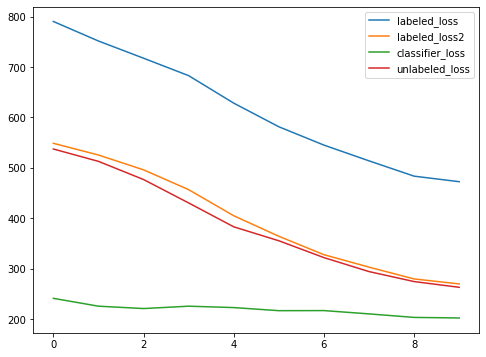

In [284]:
sample_size = 500
num_unlabeled = 500
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=epochs)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Fitting with sample_size: 500



Elapsed:  7.467520236968994
 * Accuracy: 77.6 %
 * Fit time elapsed: 7.8s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,100.000000,100.000000,100.000000,100.000000
mean,283.979861,188.273711,95.706149,189.484672
std,65.662662,18.826200,47.384467,19.730667
min,202.569031,164.321259,34.740120,163.157532
0%,202.569031,164.321259,34.740120,163.157532
25%,230.035370,174.376579,55.364150,175.342327
50%,268.355209,183.363029,84.016125,184.131332
75%,322.689789,195.826283,128.153217,196.784424
95%,411.355505,228.210334,181.742480,223.733881
99%,450.249199,249.678320,200.570879,250.006568


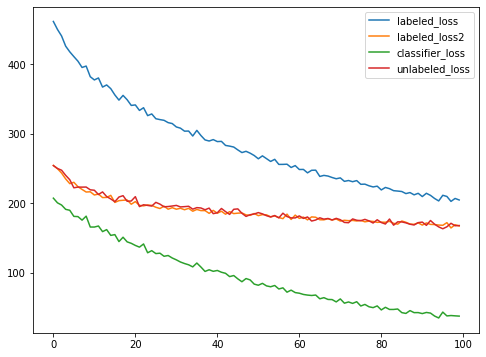

In [285]:
sample_size = 500
num_unlabeled = 5000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=epochs)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

Fitting with sample_size: 500



Elapsed:  71.31690502166748
 * Accuracy: 81.4 %
 * Fit time elapsed: 72.3s


,labeled_loss,labeled_loss2,classifier_loss,unlabeled_loss
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,141.149607,134.466333,6.683274,144.348674
std,19.557312,11.471096,9.151254,7.507623
min,121.508911,119.598579,1.386199,131.872620
0%,121.508911,119.598579,1.386199,131.872620
25%,127.994280,125.455622,2.546442,139.163616
50%,134.529495,130.864967,3.691752,142.166061
75%,147.258720,140.596649,6.658880,147.192257
95%,180.689011,159.578423,21.123246,160.802869
99%,215.753432,165.855564,50.222576,168.453120


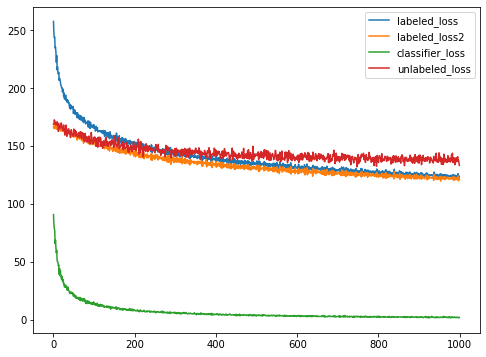

In [286]:
sample_size = 500
num_unlabeled = 50000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size+num_unlabeled, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]


start = time.time()
print('Fitting with sample_size: {}'.format(sample_size))
if sample_size < len(X_train_subset):
    sss = StratifiedShuffleSplit(n_splits=2, test_size=sample_size / len(X_train_subset), random_state=0)
    _, index = sss.split(X_train_subset, y_train_subset)
    X_lab, y_lab = X_train_subset[index[1]], y_train_subset[index[1]]
    X_others, _ = X_train_subset[index[0]], y_train_subset[index[0]]
else:
    X_lab, y_lab = X_train_subset, y_train_subset


history = fit_model(X_others, X_lab, y_lab, epochs=epochs)


y_pred = np.argmax(classifier.predict(X_test, batch_size=batch_size), axis=-1)
score = accuracy_score(Y_test, y_pred)

end = time.time()
elapsed = end - start
print(' * Accuracy: %.1f %%' % (100. * score))
print(' * Fit time elapsed: %.1fs' % elapsed)

results = []
results.append({'sample_size': sample_size, 'accuracy': score, 'time': elapsed})

df = pd.DataFrame(history, columns=['labeled_loss', 'labeled_loss2', 'classifier_loss', 'unlabeled_loss'])
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df.plot(figsize=(8, 6))

In [303]:
# baseline classifier

# normalizing the data to make the neural ntwork easier to learn
x_train = normalize(X_train, axis=1)
x_test = normalize(X_test, axis=1)

#choosing the sequential model
classification_model = Sequential()

#defining the architecture of the model
X_class = Input(shape=(n_x,))
classification_model.add(X_class)
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(128, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))

#defining the parameters to train the model
classification_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


sample_size = 50000
rand_idx = np.random.choice(X_train.shape[0], size=sample_size, replace=False)
X_train_subset = X_train[rand_idx,:]
y_train_subset = y_train[rand_idx,:]

#training the model
classification_model.fit(X_train_subset, y_train_subset, epochs=3)

num_correct = 0
num_total = 100
num_rep = 10



Train on 50000 samples
Epoch 1/3


InvalidArgumentError: ignored